# week 1 심화 과제

이번에는 32x32 이미지를 보고 0~9 사이의 클래스 중 어떤 클래스 이미지인지 예측하는 문제를 실습합니다.

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
backend = "mps"

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6


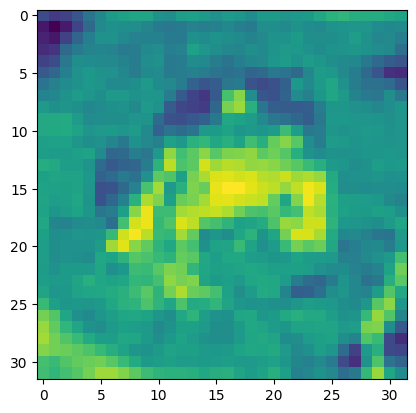

In [5]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0])

첫 번째 출력결과를 통해 우리는 5만장의 이미지가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (3, 32, 32)입니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 어떤 생명체 같은 이미지가 나오는 것을 알 수 있습니다.

In [6]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


### `images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 256로 설정했기 때문에 총 256개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 3, 32, 32) shape의 image를 입력받아 10가지의 이미지 클래스 중 하나를 출력하는 3-layer MLP를 구현합니다.

In [7]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, n_dim, label_dim, act):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, label_dim)

        self.act = act

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)

        return x

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [8]:
from torch.optim import SGD, Adam
from dataclasses import dataclass, field
from typing import List, Any

n_epochs = 50
lr = 0.001

input_dim = 32 * 32 * 3
n_dim = 1024
label_dim = 10


@dataclass
class ModelContainer:
    name: str
    model: Any
    optimizer: Any
    train_accs: List[float] = field(default_factory=list)
    test_accs: List[float] = field(default_factory=list)


sgd_model = Model(input_dim, n_dim, label_dim, nn.LeakyReLU()).to(backend)
adam_model = Model(input_dim, n_dim, label_dim, nn.LeakyReLU()).to(backend)

sgd_optimizer = SGD(sgd_model.parameters(), lr=lr)
adam_optimizer = Adam(adam_model.parameters(), lr=lr)

sgd = ModelContainer("sgd", sgd_model, sgd_optimizer)
adam = ModelContainer("adam", adam_model, adam_optimizer)

SGD와 Adam의 성능 비교를 위해 같은 모델로 옵티마이저를 만들어줍니다.

In [9]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(backend), labels.to(backend)

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt


def train_model(container, n_epochs):
    name = container.name
    model = container.model
    optimizer = container.optimizer
    train_accs = container.train_accs
    test_accs = container.test_accs

    for epoch in range(n_epochs):
        total_loss = 0.0

        model.train()
        for data in trainloader:
            model.zero_grad()

            inputs, labels = data
            inputs, labels = inputs.to(backend), labels.to(backend)

            preds = model(inputs)

            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(preds, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        with torch.no_grad():
            model.eval()
            train_accs.append(accuracy(model, trainloader))
            test_accs.append(accuracy(model, testloader))

        print(f"Name {name} | Epoch {epoch:3d} | Loss: {total_loss}")

In [10]:
train_model(sgd, n_epochs)
train_model(adam, n_epochs)

Name sgd | Epoch   0 | Loss: 449.83113741874695
Name sgd | Epoch   1 | Loss: 447.7187671661377
Name sgd | Epoch   2 | Loss: 445.81906962394714
Name sgd | Epoch   3 | Loss: 443.9553768634796
Name sgd | Epoch   4 | Loss: 441.9764201641083
Name sgd | Epoch   5 | Loss: 439.83234667778015
Name sgd | Epoch   6 | Loss: 437.5022406578064
Name sgd | Epoch   7 | Loss: 434.9456434249878
Name sgd | Epoch   8 | Loss: 432.2213251590729
Name sgd | Epoch   9 | Loss: 429.368439912796
Name sgd | Epoch  10 | Loss: 426.3939390182495
Name sgd | Epoch  11 | Loss: 423.30777311325073
Name sgd | Epoch  12 | Loss: 420.2905304431915
Name sgd | Epoch  13 | Loss: 417.27927327156067
Name sgd | Epoch  14 | Loss: 414.4494569301605
Name sgd | Epoch  15 | Loss: 411.75361251831055
Name sgd | Epoch  16 | Loss: 409.26788783073425
Name sgd | Epoch  17 | Loss: 406.92153215408325
Name sgd | Epoch  18 | Loss: 404.7084529399872
Name sgd | Epoch  19 | Loss: 402.6691461801529
Name sgd | Epoch  20 | Loss: 400.7795692682266
Name s

In [11]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to(backend)

sgd_pred = sgd.model(x)
adam_pred = adam.model(x)

print(torch.argmax(sgd_pred), sgd_pred)
print(torch.argmax(adam_pred), adam_pred)
print(trainset[idx][1])

tensor(6, device='mps:0') tensor([[-2.6502,  0.2195,  0.4404,  1.2049,  1.1574,  1.1495,  2.2713,  0.7364,
         -2.7541, -0.9384]], device='mps:0', grad_fn=<LinearBackward0>)
tensor(6, device='mps:0') tensor([[ -7.3298,  -5.0124,  -0.3214,  -1.3946,   0.9472,  -3.3880,   6.2091,
           0.2326,  -4.6317, -10.5470]], device='mps:0',
       grad_fn=<LinearBackward0>)
6


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 둘 다 아직 성능이 좋지 않지만, sgd보다 adam 이 성능이 좋은 것을 확인할 수 있습니다.

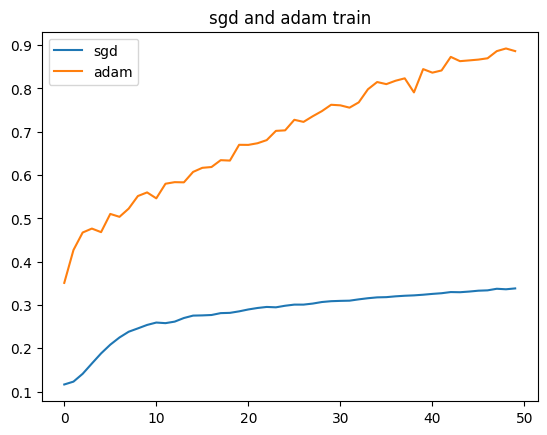

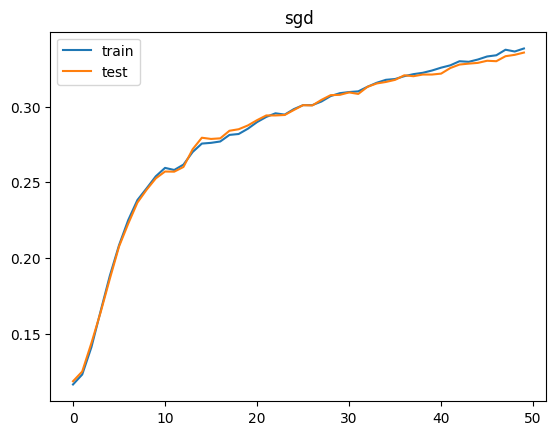

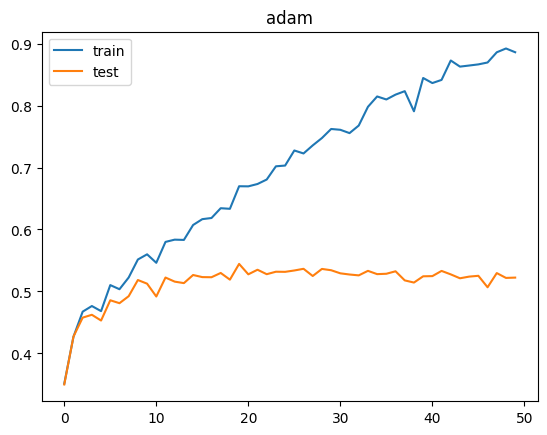

In [12]:
import numpy as np


def plot_acc(
    train_accs, test_accs, title="tranin and test", label1="train", label2="test"
):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)

    plt.title(title)
    plt.legend()
    plt.show()


plot_acc(sgd.train_accs, adam.train_accs, "sgd and adam train", sgd.name, adam.name)
plot_acc(sgd.train_accs, sgd.test_accs, sgd.name)
plot_acc(adam.train_accs, adam.test_accs, adam.name)

In [13]:
adam_sigmoid_model = Model(input_dim, n_dim, label_dim, nn.Sigmoid()).to(backend)
adam_leakyReLU_model = Model(input_dim, n_dim, label_dim, nn.LeakyReLU()).to(backend)

adam_sigmoid = ModelContainer(
    "adam_sigmoid", adam_sigmoid_model, Adam(adam_sigmoid_model.parameters(), lr=lr)
)
adam_leakyReLU = ModelContainer(
    "adam_leakyReLU",
    adam_leakyReLU_model,
    Adam(adam_leakyReLU_model.parameters(), lr=lr),
)

In [14]:
train_model(adam_sigmoid, n_epochs)
train_model(adam_leakyReLU, n_epochs)

Name adam_sigmoid | Epoch   0 | Loss: 388.67875492572784
Name adam_sigmoid | Epoch   1 | Loss: 341.7724361419678
Name adam_sigmoid | Epoch   2 | Loss: 322.3031860589981
Name adam_sigmoid | Epoch   3 | Loss: 310.35992109775543
Name adam_sigmoid | Epoch   4 | Loss: 302.4697972536087
Name adam_sigmoid | Epoch   5 | Loss: 291.74500596523285
Name adam_sigmoid | Epoch   6 | Loss: 286.36661672592163
Name adam_sigmoid | Epoch   7 | Loss: 281.57496535778046
Name adam_sigmoid | Epoch   8 | Loss: 277.56181704998016
Name adam_sigmoid | Epoch   9 | Loss: 270.82490384578705
Name adam_sigmoid | Epoch  10 | Loss: 267.307976603508
Name adam_sigmoid | Epoch  11 | Loss: 262.16726636886597
Name adam_sigmoid | Epoch  12 | Loss: 258.2342041730881
Name adam_sigmoid | Epoch  13 | Loss: 256.40629255771637
Name adam_sigmoid | Epoch  14 | Loss: 252.50843572616577
Name adam_sigmoid | Epoch  15 | Loss: 245.2004075050354
Name adam_sigmoid | Epoch  16 | Loss: 243.3931370973587
Name adam_sigmoid | Epoch  17 | Loss: 2

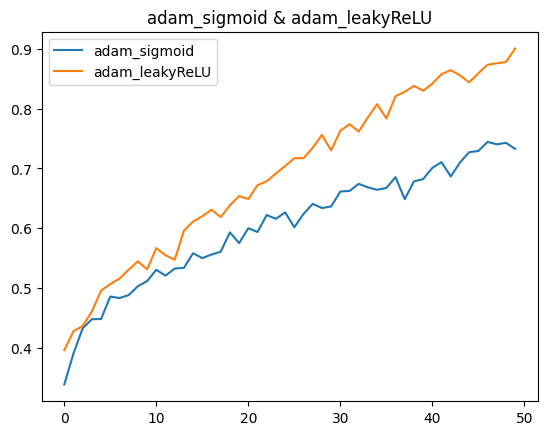

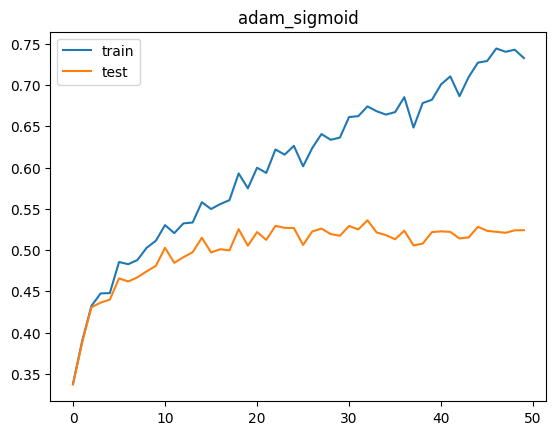

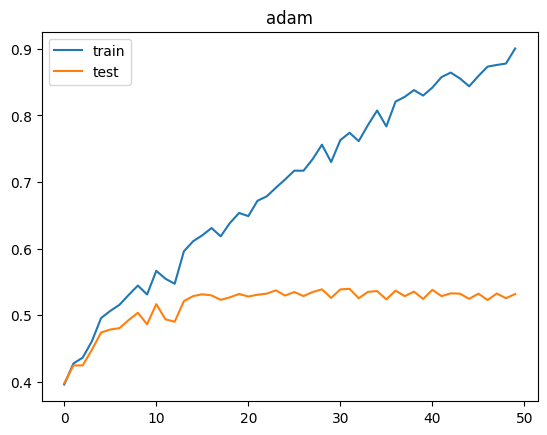

In [15]:
plot_acc(
    adam_sigmoid.train_accs,
    adam_leakyReLU.train_accs,
    adam_sigmoid.name + " & " + adam_leakyReLU.name,
    adam_sigmoid.name,
    adam_leakyReLU.name,
)
plot_acc(adam_sigmoid.train_accs, adam_sigmoid.test_accs, adam_sigmoid.name)
plot_acc(adam_leakyReLU.train_accs, adam_leakyReLU.test_accs, adam.name)

In [16]:
adam_sigmoid_pred = adam_sigmoid.model(x)
adam_leakyReLU_pred = adam_leakyReLU.model(x)

adam_sigmoid_pred_argmax = torch.argmax(adam_sigmoid_pred)
adam_leakyReLU_pred_argmax = torch.argmax(adam_leakyReLU_pred)


print(
    adam_sigmoid_pred_argmax.item(),
    adam_sigmoid_pred[0][adam_sigmoid_pred_argmax].item(),
    "\n",
    adam_sigmoid_pred,
)
print(
    adam_leakyReLU_pred_argmax.item(),
    adam_leakyReLU_pred[0][adam_leakyReLU_pred_argmax].item(),
    "\n",
    adam_leakyReLU_pred,
)
print(trainset[idx][1])

6 4.9180169105529785 
 tensor([[-3.6532, -3.7980, -1.7745,  0.9671, -1.9728, -1.3188,  4.9180, -1.6749,
         -8.0777, -6.1890]], device='mps:0', grad_fn=<LinearBackward0>)
6 6.657760143280029 
 tensor([[ -3.8553, -12.1086,  -0.6542,  -0.2091,  -0.3744,  -2.4340,   6.6578,
          -0.7438, -10.8170, -10.6061]], device='mps:0',
       grad_fn=<LinearBackward0>)
6


In [17]:
class DropoutModel(nn.Module):
    def __init__(self, input_dim, n_dim, label_dim, act, dropout):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, label_dim)

        self.act = act
        self.dropout = dropout

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)

        return x

In [18]:
adam_dropout_model = DropoutModel(
    input_dim, n_dim, label_dim, nn.LeakyReLU(), nn.Dropout(0.1)
).to(backend)

adam_dropout = ModelContainer(
    "adam_dropout", adam_dropout_model, Adam(adam_dropout_model.parameters(), lr=lr)
)

In [19]:
train_model(adam_dropout, n_epochs)

Name adam_dropout | Epoch   0 | Loss: 370.0781273841858
Name adam_dropout | Epoch   1 | Loss: 331.60244500637054
Name adam_dropout | Epoch   2 | Loss: 315.8396508693695
Name adam_dropout | Epoch   3 | Loss: 303.93489944934845
Name adam_dropout | Epoch   4 | Loss: 296.97214114665985
Name adam_dropout | Epoch   5 | Loss: 288.98521637916565
Name adam_dropout | Epoch   6 | Loss: 284.2187466621399
Name adam_dropout | Epoch   7 | Loss: 279.12502098083496
Name adam_dropout | Epoch   8 | Loss: 274.6715180873871
Name adam_dropout | Epoch   9 | Loss: 268.8817300796509
Name adam_dropout | Epoch  10 | Loss: 264.89262998104095
Name adam_dropout | Epoch  11 | Loss: 261.84280610084534
Name adam_dropout | Epoch  12 | Loss: 258.73947298526764
Name adam_dropout | Epoch  13 | Loss: 254.36031877994537
Name adam_dropout | Epoch  14 | Loss: 250.7603816986084
Name adam_dropout | Epoch  15 | Loss: 247.59312427043915
Name adam_dropout | Epoch  16 | Loss: 243.90711617469788
Name adam_dropout | Epoch  17 | Loss:

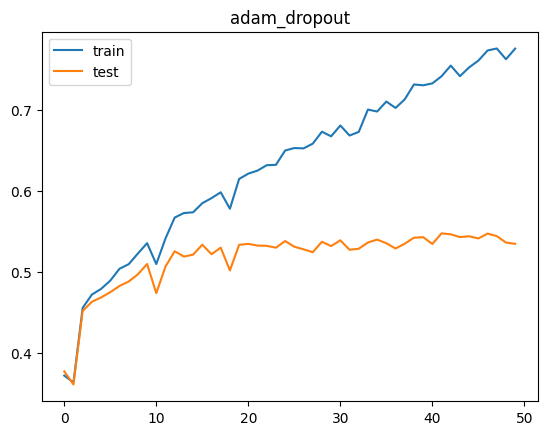

In [20]:
plot_acc(adam_dropout.train_accs, adam_dropout.test_accs, adam_dropout.name)

In [21]:
adam_dropout_pred = adam_dropout.model(x)

adam_dropout_pred_argmax = torch.argmax(adam_dropout_pred)

print(
    adam_dropout_pred_argmax.item(),
    adam_dropout_pred[0][adam_dropout_pred_argmax].item(),
    "\n",
    adam_dropout_pred,
)
print(trainset[idx][1])

6 5.214222431182861 
 tensor([[-2.5577, -3.2831,  1.2157, -0.3890, -1.0856,  0.7357,  5.2142, -2.5125,
         -4.2251, -4.7497]], device='mps:0', grad_fn=<LinearBackward0>)
6
